# Table of Contents <a id="table-of-contents"></a>

- [Imports](#imports)
- [Data Loading](#data-loading)
- [Data Overview](#data-overview)
    - [Number of Samples](#number-of-samples)
    - [Sample Data](#sample-data)
- [Viewing the OCT Images](#viewing-the-oct-images)
    - [Axial View](#axial-view)
    - [Coronal View](#coronal-view)
    - [Sagittal View](#sagittal-view)
- [Data Splitting](#data-splitting)
    - [Train/Test/Validation Split](#train-test-validation-split)
    - [Class Distribution](#class-distribution)
- [Data Augmentation](#data-augmentation)
    - [Augmentation Methods](#augmentation-methods)
    - [Augmentation Results](#augmentation-results)
- [Histograms](#histograms)
    - [Brightness](#brightness)
    - [Contrast](#contrast)
    - [Gamma Correction](#gamma-correction)
    - [Histogram Equalization](#histogram-equalization)
    - [Gaussian Noise](#gaussian-noise)
    - [Blurring](#blurring)
    - [Sharpening](#sharpening)
    - [Blurring then Sharpening](#blurring-then-sharpening)
- [Affine Transformations](#affine-transformations)
    - [Small Translation](#small-translation)
    - [Scaling (Mild)](#scaling-mild)
    - [Elastic Deformation](#elastic-deformation)
- [Cutout and Random Erasing](#cutout-and-random-erasing)
    - [Cutout](#cutout)
    - [Random Erasing](#random-erasing)

# Imports <a id="imports"></a>

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
import cv2 as cv

<a id="data-loading"></a>
# Data Loading
[Back to Top](#table-of-contents)

In [2]:
import data_load

data_loader = data_load.DataLoader()
# image_data, np_array_data, labels_data = data_loader.retina()
np_array_data, labels_data, patient_id, eye_side = data_loader.retina_npy()

In [3]:
print(labels_data[890])
print(labels_data[15])

1
0


In [4]:
print(len(np_array_data))
print(len(labels_data))
print(len(patient_id))
print(len(eye_side))

1110
1110
1110
1110


In [5]:
np_array_data.dtype

dtype('uint8')

In [6]:
%%capture
# print(image_data[0])

In [7]:
%%capture
print(np_array_data[0])

In [8]:
labels_data.sum()

np.int64(847)

In [9]:
#%%capture
print("poaGlaucoma: ", labels_data.sum(), "  Healthy:", len(labels_data)-labels_data.sum())

poaGlaucoma:  847   Healthy: 263


0.3105076741440378

In [17]:
#train test split
train_volumes, test_volumes, train_labels, test_labels, train_patient_id, test_patient_id, train_eye_side, test_eye_side = data_loader.retina_npy_split(np_array_data, labels_data, patient_id, eye_side)
print(f"Train data shape: {train_volumes.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_volumes.shape}, Test labels shape: {test_labels.shape}")
num_glaucoma = sum(train_labels)
num_healthy = len(train_labels) - num_glaucoma

Loading train and test indeces...
Splitting train and test data ...
Train data shape: (882, 64, 128, 64), Train labels shape: (882,)
Test data shape: (228, 64, 128, 64), Test labels shape: (228,)


In [27]:
215/667

0.32233883058470764

In [19]:
train_volumes.shape, train_labels.shape, num_glaucoma, num_healthy

((882, 64, 128, 64), (882,), np.int64(667), np.int64(215))

In [ ]:
263

In [ ]:
number_healthy = len(labels_data)-labels_data.sum()
number_glaucoma = labels_data.sum()
proportion= np.round(number_healthy/number_glaucoma, 3)
random_vector = np.random.rand(train_volumes.shape[0])
new_train_volumes = train_volumes[random_vector< proportion]
new_train_labels = train_labels[random_vector< proportion]

In [25]:
new_train_volumes.shape, new_train_labels.shape, sum(new_train_labels), len(new_train_labels) - sum(new_train_labels)

((268, 64, 128, 64), (268,), np.int64(206), np.int64(62))

In [33]:
# Data loading and preprocessing
data_loader = data_load.DataLoader()
print("Loading data...")
volumes, labels, patient_id, eye_side = data_loader.retina_npy()
print("Splitting data...")
train_volumes, test_volumes, train_labels, test_labels, train_patient_id, test_patient_id, train_eye_side, test_eye_side = data_loader.retina_npy_split(volumes, labels, patient_id, eye_side)
print(f"Train data shape: {train_volumes.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_volumes.shape}, Test labels shape: {test_labels.shape}")
num_glaucoma = np.sum(train_labels == 1)
num_healthy = np.sum(train_labels == 0)

# balance the dataset without augmentation by random deletion
# Count healthy (label 0) and glaucoma (label 1) in the full dataset
proportion = np.round(num_healthy / num_glaucoma, 3)

# Get indices for class 0 and class 1 in training set
healthy_indices = np.where(train_labels == 0)[0]
print(f"Number of healthy samples: {len(healthy_indices)}")
glaucoma_indices = np.where(train_labels == 1)[0]
print(f"Number of glaucoma samples: {len(glaucoma_indices)}")

# Randomly sample a proportion of glaucoma indices
np.random.seed(42)  # for reproducibility
selected_glaucoma_indices = np.random.choice(
    glaucoma_indices, 
    size=int(len(glaucoma_indices) * proportion), 
    replace=False
)

# Combine indices and shuffle
balanced_indices = np.concatenate([healthy_indices, selected_glaucoma_indices])
np.random.shuffle(balanced_indices)

# Subset the training data
train_volumes = train_volumes[balanced_indices]
train_labels = train_labels[balanced_indices]
train_patient_id = train_patient_id[balanced_indices]

print(f"Balanced train data shape: {train_volumes.shape}, Balanced train labels shape: {train_labels.shape}")

Loading data...
Splitting data...
Loading train and test indeces...
Splitting train and test data ...
Train data shape: (882, 64, 128, 64), Train labels shape: (882,)
Test data shape: (228, 64, 128, 64), Test labels shape: (228,)
Number of healthy samples: 215
Number of glaucoma samples: 667
Balanced train data shape: (429, 64, 128, 64), Balanced train labels shape: (429,)


In [ ]:
300

In [29]:
len(train_volumes), len(train_labels), sum(train_labels), len(train_labels) - sum(train_labels)

(429, 429, np.int64(214), np.int64(215))

In [32]:
429*0.8

343.20000000000005

# Viewing the OCT images
[Back to Top](#table-of-contents)
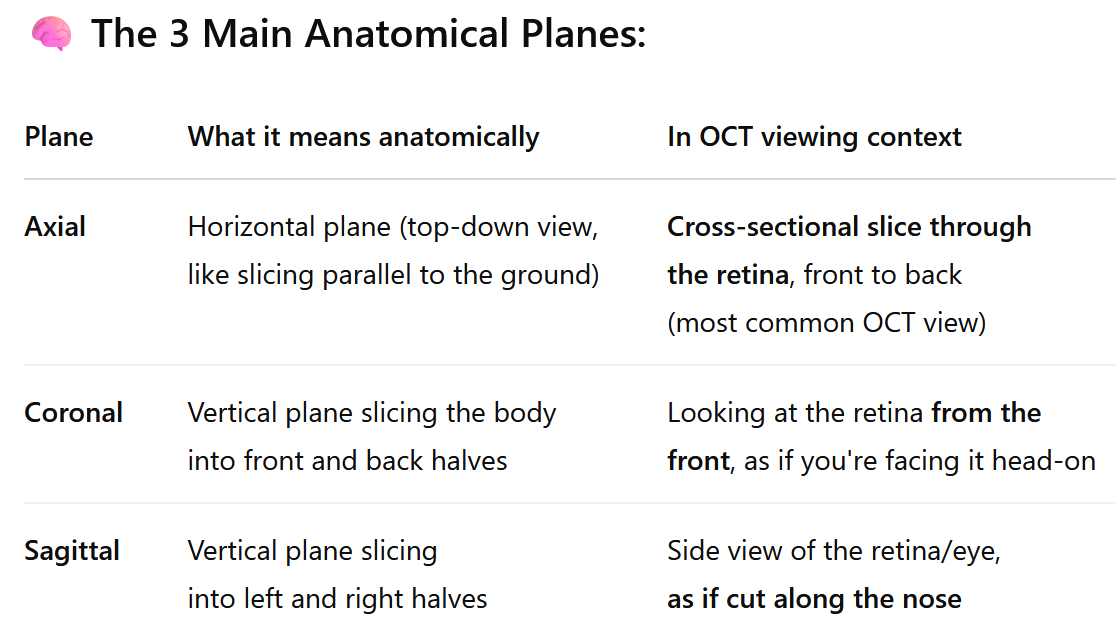


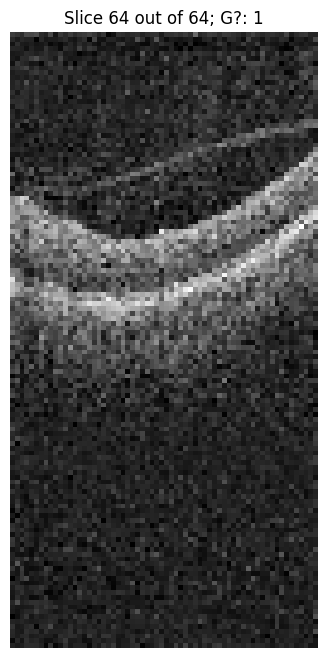

In [21]:
id = 1000
array = np_array_data[id]
label = labels_data[id]

# Display axial view 
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

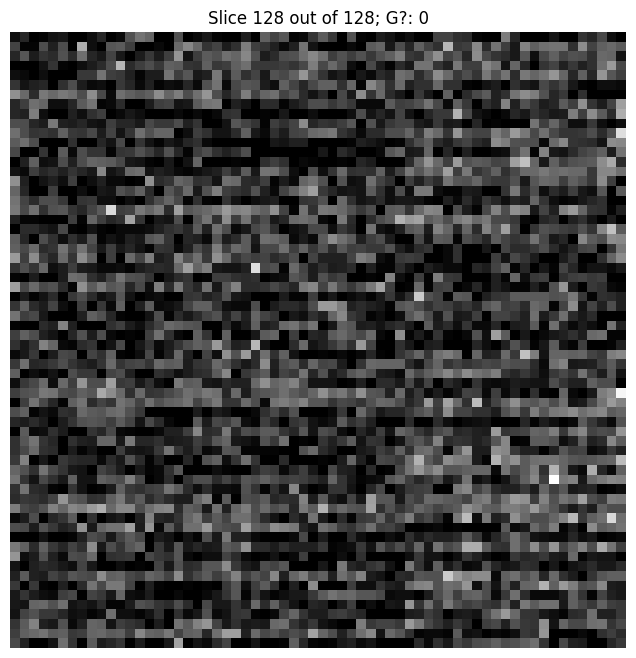

In [14]:
# Display coronal view
# This view shows a slice of the retina from the front to the back
# This view is going from the top to the bottom in the previous view (birds eye view)
# Note the nerve structure in the centre of the image towards to second half of the anymation
for i in range(array.shape[1]):
    slice_num = i
    slice = array[:, slice_num, :]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[1]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

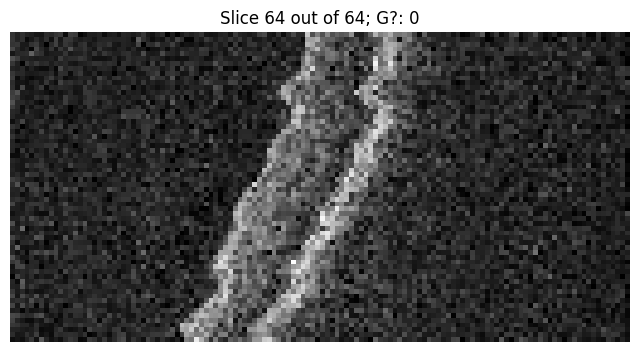

In [ ]:
# Display sagittal view
for i in range(array.shape[2]):
    slice_num = i
    slice = array[:, :, slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[2]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

# Splitting the data
[Back to Top](#table-of-contents)

In [ ]:
# TODO This is splitting patients across the three sets
X_train, X_test, X_val, y_train, y_test, y_val = data_loader.retina_split(np_array_data,labels_data)

In [ ]:
print(len(X_train),len(X_test),len(X_val))

754 222 134


In [ ]:
train_positive_pecentage = sum(y_train)/len(y_train)
test_positive_pecentage = sum(y_test)/len(y_test)
val_positive_pecentage = sum(y_val)/len(y_val)

print("train positives:", np.round(train_positive_pecentage,3), "  ---  test positives:", np.round(test_positive_pecentage,3), "  ---  val positives:", np.round(val_positive_pecentage,3))

train positives: 0.761   ---  test positives: 0.793   ---  val positives: 0.724


# Data Augmentation
[Back to Top](#table-of-contents)

The data is between 70% and 80% glaucoma positive.

- How many images should I produce:
    - balance out the healthy class
    - See results below



In [ ]:
# healthy = 0 vs glaucomatous = 1 in the train data
glaucoma = sum(y_train)
glaucoma_cent = glaucoma/len(y_train)
healthy = len(y_train) - glaucoma
healthy_cent = healthy/len(y_train)
print("healthy: ", healthy,"healthy percentage:", np.round(healthy_cent, 4))
print("glaucoma: ", glaucoma,"glaucoma percentage:", np.round(glaucoma_cent, 4))
print("Samples to be produced in augmentation: ", glaucoma-healthy)

healthy:  180 healthy percentage: 0.2387
glaucoma:  574 glaucoma percentage: 0.7613
Samples to be produced in augmentation:  394


## Methods
[Back to Top](#table-of-contents)
- Over- or undersampling?
    - undersampling risks information loss
        - Undersampling with ensemble learning
    - oversampling
        - seems unrealistic for images as techniques are built for tabular data
- image transformations? -> these are medical images so not all transformations are realistic and sensible
- The methods below seem reasonable
    - Intensity based augmentations
        - Brightness adjustment
        - Contrast changes
        - Gamma correction
        - Histogram equalization
        - Gaussian noise (to simulate acquisition noise)
        - Blurring/sharpening
    - Affine transfomations (mild)
        - small translations
        - mild scaling
        - elastic deformation (simulate soft tissue variation)
    - cutout/random erasing
        - how would this relate to ROAR/ patch based training



In [ ]:
# TODO: verify runnability after implementation of augmentation methods
import data_augmentation as aug

num_new_images = glaucoma-healthy
augmenter = aug.AugmentData(X_train, y_train)
print("Samples to produce in augmentation: ", num_new_images)
X_train_augmented, y_train_augmented = augmenter.augment_data(int(num_new_images), return_values="complete")

Samples to produce in augmentation:  394
Augmented data with the following methods:
Brightness changes: 30, 7.614213197969544%
Contrast changes: 40, 10.152284263959391%
Gamma changes: 43, 10.913705583756345%
Gaussian noise: 46, 11.6751269035533%
Blurring: 21, 5.32994923857868%
Blurring then sharpening: 25, 6.345177664974619%
Small translation: 50, 12.690355329949238%
Mild scaling: 46, 11.6751269035533%
Elastic deformation: 93, 23.604060913705585%
Returning both original and augmented data in one.


In [ ]:
print("augmented data shape: ", X_train_augmented.shape, y_train_augmented.shape)
glaucoma = sum(y_train_augmented)
glaucoma_cent = glaucoma/len(y_train_augmented)
healthy = len(y_train_augmented) - glaucoma
healthy_cent = healthy/len(y_train_augmented)
print("aug healthy: ", healthy,"aug healthy percentage:", np.round(healthy_cent, 4))
print("aug glaucoma: ", glaucoma,"aug glaucoma percentage:", np.round(glaucoma_cent, 4))

augmented data shape:  (1148, 64, 128, 64) (1148,)
aug healthy:  574 aug healthy percentage: 0.5
aug glaucoma:  574 aug glaucoma percentage: 0.5


<a id="histograms"></a>
### Histograms before and after augmentation
[Back to Top](#table-of-contents)

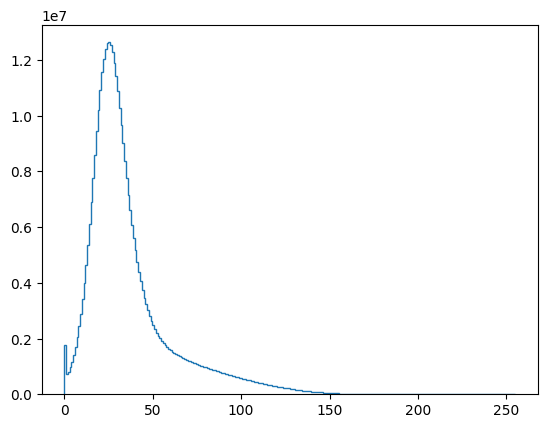

In [ ]:
# before
hist, bin_edges =np.histogram(X_train, 256, range=(0, 255))
plt.stairs(hist, bin_edges)

#### Brightness
[Back to Top](#table-of-contents)

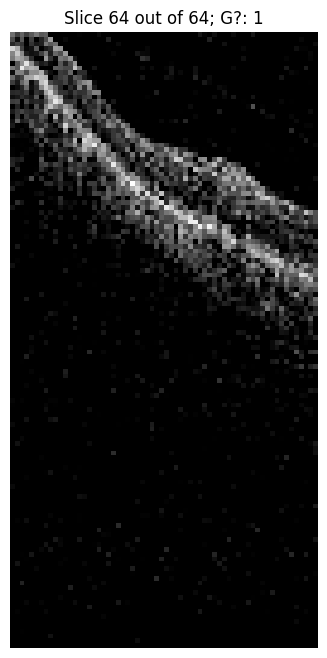

In [ ]:
id = 479
brightness = -40
array = np_array_data[id].astype(int)
label = labels_data[id]
array = np.clip(array + brightness, 0, 255).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
bright =[image.astype(int)-40 for image in X_train]
hist_min, bin_edges_min =np.histogram(np.clip(bright, 0, 255).astype(np.uint8), 256, range=(0, 255))
lowlight = [image.astype(int)+40 for image in X_train]
hist_max, bin_edges_max =np.histogram(np.clip(lowlight, 0, 255).astype(np.uint8), 256, range=(0, 255))

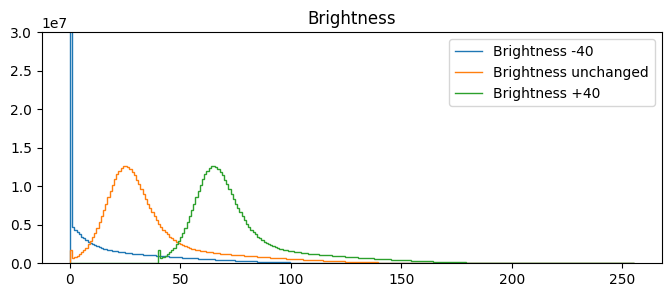

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_min, bin_edges_min, label='Brightness -40')
axs.stairs(hist, bin_edges, label='Brightness unchanged')
axs.stairs(hist_max, bin_edges_max, label='Brightness +40')
axs.set_title("Brightness")
axs.set_ylim([0, 30000000])
axs.legend()

#### Contrast
[Back to Top](#table-of-contents)

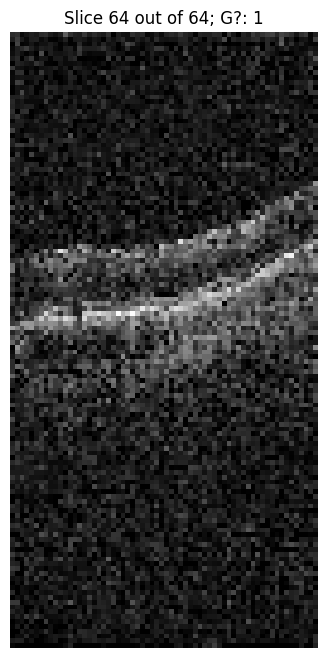

In [ ]:
id = 379
contrast_factor = 1.5
array = np_array_data[id].astype(int)
label = labels_data[id]
array = np.clip((array - np.mean(array)) * contrast_factor + np.mean(array), 0, 255).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
X_trainy = X_train.copy()
np.random.shuffle(X_trainy)

In [ ]:
hist_cont_min, bin_edges_cont_min =np.histogram(np.clip([(image.astype(int) - np.mean(image)) * 0.5 + np.mean(image) for image in X_trainy[0:300]], 0, 255).astype(np.uint8), 256, range=(0, 255))
hist_cont_max, bin_edges_cont_max =np.histogram(np.clip([(image.astype(int) - np.mean(image)) * 1.5 + np.mean(image) for image in X_trainy[0:300]], 0, 255).astype(np.uint8), 256, range=(0, 255))

MemoryError: Unable to allocate 1.17 GiB for an array with shape (300, 64, 128, 64) and data type float64

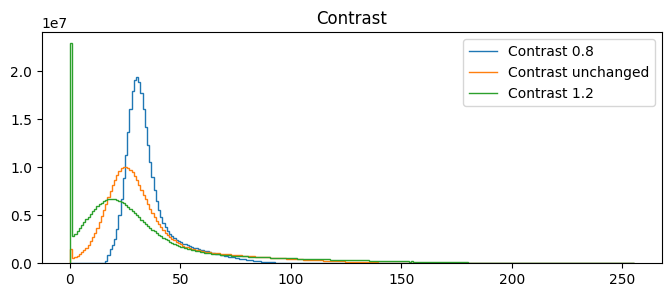

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_cont_min, bin_edges_cont_min, label='Contrast 0.5')
axs.stairs(hist, bin_edges, label='Contrast unchanged')
axs.stairs(hist_cont_max, bin_edges_cont_max, label='Contrast 1.5')
axs.set_title("Contrast")
# axs.set_ylim([0, 30000000])
axs.legend()

#### Gamma correction
[Back to Top](#table-of-contents)

In [ ]:
def gamma_correction(image, gamma):
    lookUpTable = np.empty((1,256)).astype(np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(((i / 255.0)** gamma) * 255.0, 0, 255).astype(np.uint8)   
    return cv.LUT(image.astype(np.uint8), lookUpTable)

In [ ]:
id = 479
gamma = 0.75
array = np_array_data[id].astype(np.uint8)
print(array.dtype)
label = labels_data[id]
array = gamma_correction(array, gamma)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

NameError: name 'np_array_data' is not defined

In [ ]:
hist_gamma_min, bin_edges_gamma_min =np.histogram(np.clip([gamma_correction(image, 0.75) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))
hist_gamma_max, bin_edges_gamma_max =np.histogram(np.clip([gamma_correction(image, 1.5 )for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

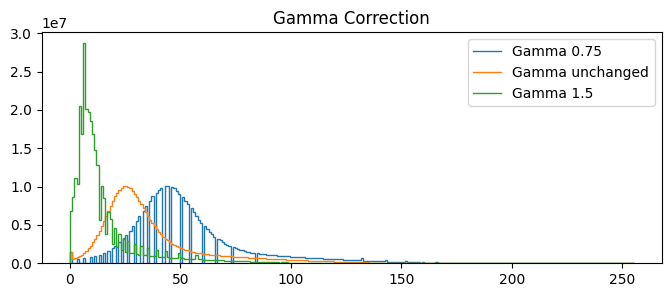

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_gamma_min, bin_edges_gamma_min, label='Gamma 0.75')
axs.stairs(hist, bin_edges, label='Gamma unchanged')
axs.stairs(hist_gamma_max, bin_edges_gamma_max, label='Gamma 1.5')
axs.set_title("Gamma Correction")
# axs.set_ylim([0, 30000000])
axs.legend()

<a id="histogram-equalization"></a>
#### Histogram Equalization
[Back to Top](#table-of-contents)

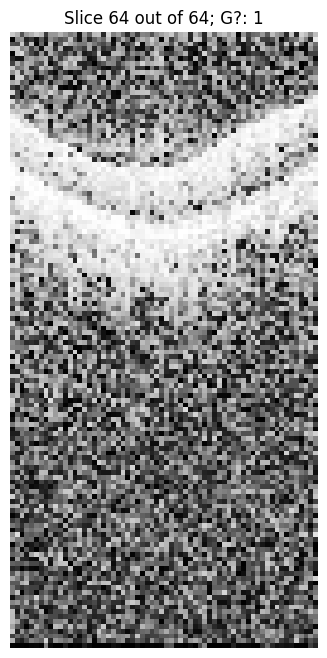

In [ ]:
#histogram equalization
id = 479
array = np_array_data[id]
label = labels_data[id]

array = np.array([cv.equalizeHist(slice) for slice in array])
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
hist_histeq, bin_edges_histeq =np.histogram(np.clip([np.array([cv.equalizeHist(slice) for slice in image]) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

In [ ]:
# a,b = np.histogram(np.clip([np.array([cv.equalizeHist(slice) for slice in array])], 0, 255).astype(np.uint8), 256, range=(0, 255))

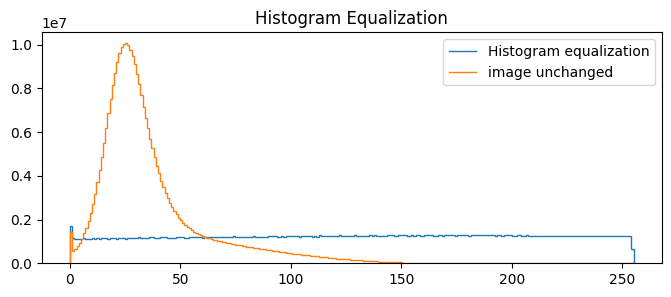

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_histeq, bin_edges_histeq, label='Histogram equalization')
axs.stairs(hist, bin_edges, label='image unchanged')
# axs.stairs(a, b, label='image unchanged')
axs.set_title("Histogram Equalization")
axs.legend()

#### Gaussian noise

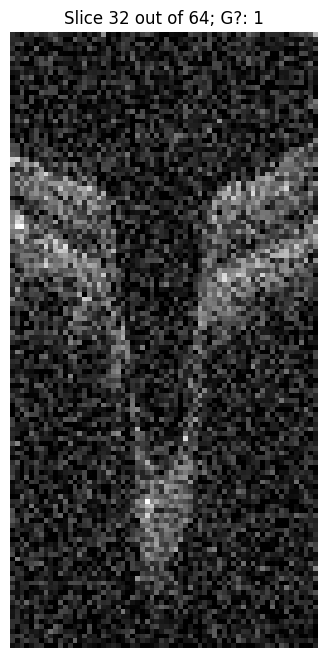

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
noise = np.random.normal(0, 25, array.shape)
noisy_array = array.astype(np.float32) + noise  # add in float
array = np.clip(noisy_array, 0, 255).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
x_train_gauss = np.clip([image.astype(np.float32) + np.random.normal(0, 15, image.shape) for image in X_train], 0, 255).astype(np.uint8)

In [ ]:
hist_gauss_max, bin_edges_gauss_max =np.histogram(x_train_gauss, 256, range=(0, 255))

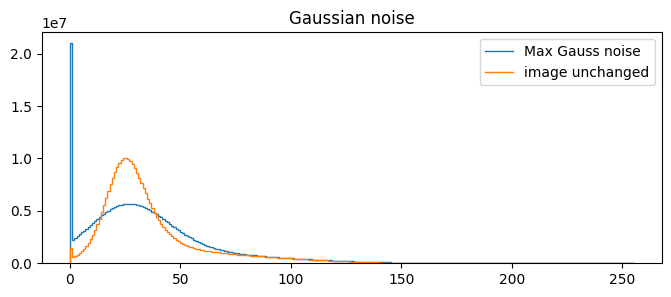

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_gauss_max, bin_edges_gauss_max, label='Max Gauss noise')
axs.stairs(hist, bin_edges, label='image unchanged')
# axs.stairs(a, b, label='image unchanged')
axs.set_title("Gaussian noise")
axs.legend()

In [ ]:
print(np.std(X_train),np.mean(X_train))

24.340632320520196 35.92591899553935


In [ ]:
print(np.std(x_train_gauss),np.mean(x_train_gauss))

27.811769478489854 35.9385981241862


#### Blurring

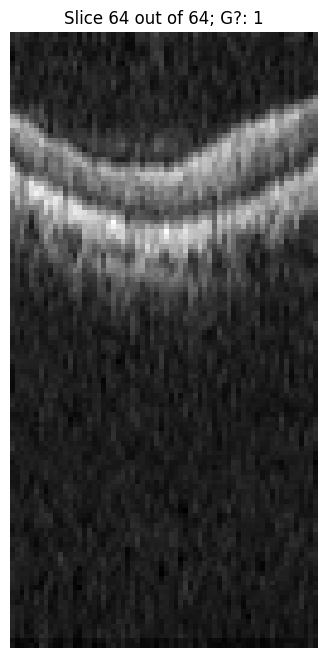

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
array = cv.filter2D(array, -1, np.ones((3, 3), np.float32) / 9).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)

    clear_output(wait=True)

In [ ]:
hist_blur_min, bin_edges_blur_min =np.histogram(np.clip([cv.filter2D(image, -1, np.ones((2, 2), np.float32) / 4).astype(np.uint8) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))
hist_blur_max, bin_edges_blur_max =np.histogram(np.clip([cv.filter2D(image, -1, np.ones((5, 5), np.float32) / 25).astype(np.uint8) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

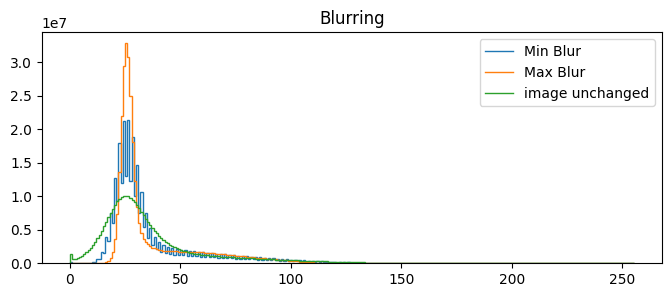

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_blur_min, bin_edges_blur_min, label='Min Blur')
axs.stairs(hist_blur_max, bin_edges_blur_max, label='Max Blur')
axs.stairs(hist, bin_edges, label='image unchanged')
# axs.stairs(a, b, label='image unchanged')
axs.set_title("Blurring")
axs.legend()

5x5 feels to intense and since kernels are usually odd sized I chose 3x3

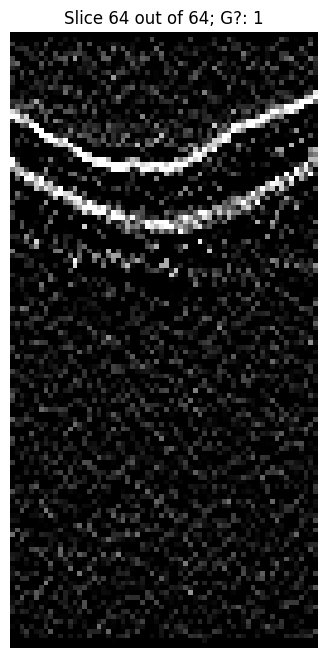

In [ ]:
#Irrelevant fun with sobel kernels
id = 479
array = np_array_data[id]
label = labels_data[id]

kernel = np.array([
  [-1, -2, -1],
  [0, 0, 0],
  [1, 2, 1]
])
kernel2 = np.array([
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1]
])
 
 
array1 = cv.filter2D(array, -1, kernel)
array2 = cv.filter2D(array, -1, kernel2)

array1 = np.clip(array1, 0, 255).astype(int)
array2 = np.clip(array2, 0, 255).astype(int)

gradient_magnitude = np.sqrt(array1**2 + array2**2)

# Optionally, convert back to uint8
array = np.uint8(np.clip(gradient_magnitude, 0, 255))


for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    # time.sleep(0.3)
    clear_output(wait=True)

#### Sharpening

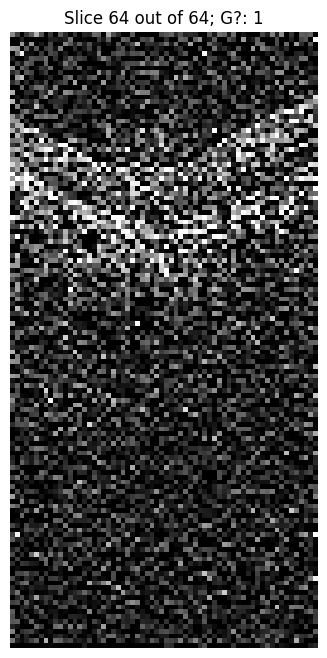

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
kernel= np.array([
  [0, -1, 0],
  [-1, 5, -1],
  [0, -1, 0]
])
array = cv.filter2D(array, -1, kernel).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

This produces an unrealistic image that won't be acceptable in sharpness in practice

#### Blurring then sharpening

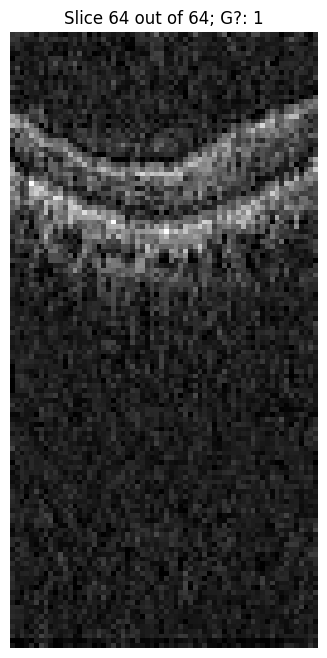

In [ ]:
# first blur then sharpen

id = 479
array = np_array_data[id]
label = labels_data[id]
kernel= np.array([
  [0, -1, 0],
  [-1, 5, -1],
  [0, -1, 0]
])
array = cv.filter2D(array, -1, np.ones((3, 3), np.float32) / 9).astype(np.uint8)
array = cv.filter2D(array, -1, kernel).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    ##time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
hist_blur_sharp, bin_edges_blur_sharp = np.histogram(np.clip([cv.filter2D(cv.filter2D(image, -1, np.ones((3, 3), np.float32) / 9).astype(np.uint8), -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])).astype(np.uint8) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

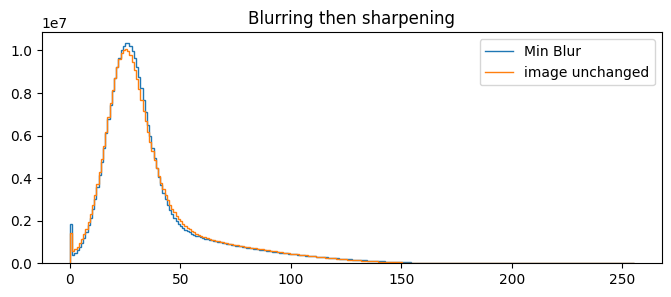

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_blur_sharp, bin_edges_blur_sharp, label='Min Blur')
axs.stairs(hist, bin_edges, label='image unchanged')
# axs.stairs(a, b, label='image unchanged')
axs.set_title("Blurring then sharpening")
axs.legend()

#### Small translation

In [ ]:
import random

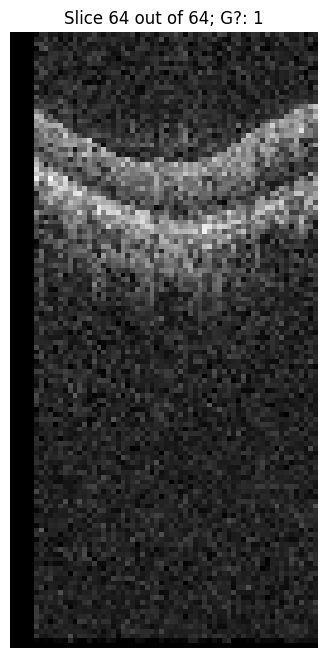

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
tx = random.randint(-5, 5)
ty = random.randint(-5, 5)
M = np.float32([[1, 0, tx], [0, 1, ty]])
array = np.array([cv.warpAffine(slice, M, (slice.shape[1], slice.shape[0])).astype(np.uint8) for slice in array ])
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    #time.sleep(0.3)
    clear_output(wait=True)

The histogram here is not interesting since the empty space is just filled with zero padding

#### Scaling (mild)

In [ ]:
def mild_scaling(volume, scale=0.75):
    center_x = volume.shape[0] // 2
    center_y = volume.shape[1] // 2

    M = np.float32([
        [scale, 0, (1 - scale) * center_x],
        [0, scale, (1 - scale) * center_y]
    ])

    # M = np.float32([[scale, 0, 0], [0, scale, 0]])
    scaled_volume = np.array([cv.warpAffine(slice, M, (volume.shape[0],volume.shape[1])) for slice in volume])
    return scaled_volume.astype(np.uint8)

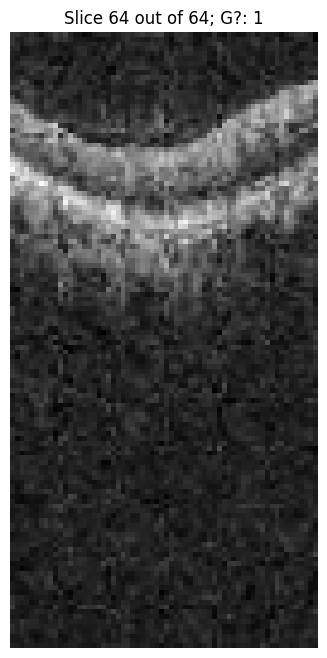

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
array = mild_scaling(array, scale=1.1)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    #time.sleep(0.3)
    clear_output(wait=True)

#### Elastic deformation


| `alpha` | `sigma` | Result                                           |
|---------|--------|--------------------------------------------------|
| 5       | 3      | Subtle, barely noticeable                        |
| 10      | 4      | Gentle anatomical shifts                         |
| 20      | 5      | Clearly warped, but smooth                       |
| 30      | 3      | Very noticeable and bumpy                        |
| 15      | 1      | Harsh, almost noisy distortions (not recommended) |

In [ ]:
from scipy.ndimage import gaussian_filter, map_coordinates

In [ ]:
def elastic_deformation_3d(volume, alpha=10, sigma=2, random_state=None):
    """
    Apply elastic deformation to a 3D volume.
    
    Args:
        volume (ndarray): 3D array with shape (D, H, W)
        alpha (float): Scaling factor for the intensity of the deformation
        sigma (float): Standard deviation of the Gaussian filter (controls smoothness)
        random_state (int or None): Seed for reproducibility
    
    Returns:
        ndarray: Deformed 3D volume of same shape, dtype=np.uint8
    """
    if random_state is None:
        random_state = np.random.RandomState(None)
    elif isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)

    shape = volume.shape

    # Generate random displacement fields and smooth them
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # Create meshgrid of indices
    z, y, x = np.meshgrid(
        np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]),
        indexing='ij'
    )

    # Apply deformation
    indices = np.reshape(z + dz, (-1,)), np.reshape(y + dy, (-1,)), np.reshape(x + dx, (-1,))
    distorted = map_coordinates(volume, indices, order=1, mode='reflect').reshape(shape)

    return np.clip(distorted, 0, 255).astype(np.uint8)

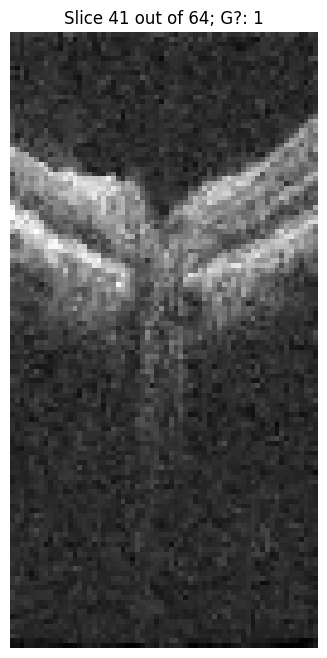

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
array = elastic_deformation_3d(array, alpha=10, sigma=2, random_state=None)
for i in range(array.shape[0]//3,array.shape[0]//3+20):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    #time.sleep(0.3)
    clear_output(wait=True)

#### Cutout

In [ ]:
import random

In [ ]:
def cutout_3d(volume, mask_size_range=(10, 30)):
    d, h, w = volume.shape
    mask_d = random.randint(1, min(5, d))  # keep thin in z
    mask_h = random.randint(*mask_size_range)
    mask_w = random.randint(*mask_size_range)

    z = random.randint(0, d - mask_d)
    y = random.randint(0, h - mask_h)
    x = random.randint(0, w - mask_w)

    volume[z:z+mask_d, y:y+mask_h, x:x+mask_w] = 0
    return volume.astype(np.uint8)

In [ ]:
def cutout(volume):
    h, w = volume.shape[:2]
    mask_size = random.randint(10, 30)
    x = random.randint(0, w - mask_size)
    y = random.randint(0, h - mask_size)
    volume[y:y + mask_size, x:x + mask_size] = 0
    return volume.astype(np.uint8)
    

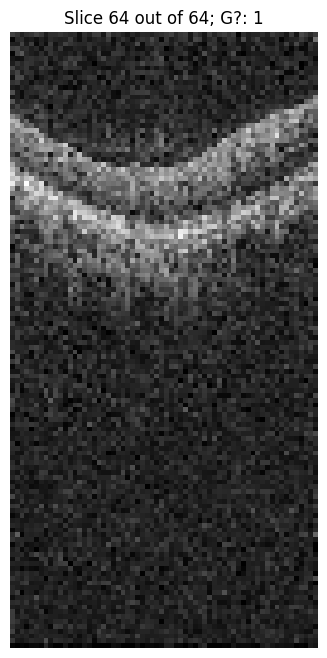

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
array = cutout_3d(array)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    #time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
def random_erasing(volume):
        h, w = volume.shape[:2]
        mask_size = random.randint(10, 30)
        x = random.randint(0, w - mask_size)
        y = random.randint(0, h - mask_size)
        volume[y:y + mask_size, x:x + mask_size] = random.randint(0, 255)
        return volume.astype(np.uint8)

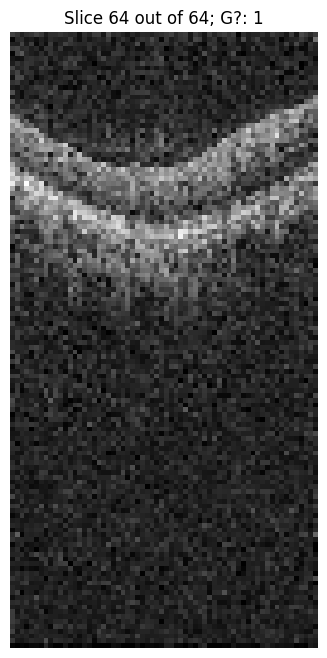

In [ ]:
id = 479
array = np_array_data[id]
label = labels_data[id]
array = random_erasing(array)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    #time.sleep(0.3)
    clear_output(wait=True)